In this file, we use the eig-decomposition

In [1]:
import scipy
import mat73
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from scipy.io import loadmat
from tqdm import trange, tqdm
from functools import partial
from pprint import pprint

from collections import defaultdict as ddict
from easydict import EasyDict as edict


%matplotlib inline

In [2]:
# import my own functions
import sys
sys.path.append("../../mypkg")
import importlib

# paras
import paras
importlib.reload(paras);
from paras import paras

# some useful constants
import constants
importlib.reload(constants)
from constants import REGION_NAMES, REGION_NAMES_WLOBE, RES_ROOT, DATA_ROOT, FIG_ROOT

In [16]:
# gtvdn
import gtvdn.gtvdn_post
importlib.reload(gtvdn.gtvdn_post)
from gtvdn.gtvdn_post import est_eigvals, update_kp

import gtvdn.gtvdn_pre
importlib.reload(gtvdn.gtvdn_pre)
from gtvdn.gtvdn_pre import preprocess_MEG

import gtvdn.gtvdn_utils
importlib.reload(gtvdn.gtvdn_utils)
from gtvdn.gtvdn_utils import get_bspline_est , get_newdata, get_Amats

import gtvdn.gtvdn_det_eig
importlib.reload(gtvdn.gtvdn_det_eig)
from gtvdn.gtvdn_det_eig import screening, dyna_prog

In [4]:
# utils
import utils.matrix
importlib.reload(utils.matrix)
from utils.matrix import eig_sorted

import utils.misc
importlib.reload(utils.misc)
from utils.misc import paras2name, cumsum_cutoff, save_pkl_dict2folder, load_pkl_folder2dict

import utils.projection
importlib.reload(utils.projection)
from utils.projection import euclidean_proj_l1ball

import utils.standardize
importlib.reload(utils.standardize)
from utils.standardize import minmax, minmax_mat, minmax_pn

import utils.brain_plot
importlib.reload(utils.brain_plot)
from utils.brain_plot import reorder_U, U_2brain_vec

## Set parameters

In [5]:
pprint(paras)

{'Cs': array([1.0e+02, 2.5e+01, 1.0e+01, 5.0e+00, 2.0e+00, 1.0e+00, 5.0e-01,
       2.0e-01, 1.0e-01, 5.0e-02, 1.0e-02]),
 'L': 100.0,
 'Lmin': 200,
 'T': 2,
 'cur_dir': PosixPath('/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg'),
 'cutoff': 0.6,
 'data_dir': PosixPath('../data'),
 'decimate_rate': 5,
 'downsample_rate': 20,
 'fct': 0.5,
 'fig_dir': PosixPath('../figs'),
 'is_detrend': True,
 'kappa': 3.21,
 'kps': array([1.        , 1.003003  , 1.00600601, 1.00900901, 1.01201201,
       1.01501502, 1.01801802, 1.02102102, 1.02402402, 1.02702703,
       1.03003003, 1.03303303, 1.03603604, 1.03903904, 1.04204204,
       1.04504505, 1.04804805, 1.05105105, 1.05405405, 1.05705706,
       1.06006006, 1.06306306, 1.06606607, 1.06906907, 1.07207207,
       1.07507508, 1.07807808, 1.08108108, 1.08408408, 1.08708709,
       1.09009009, 1.09309309, 1.0960961 , 1.0990991 , 1.1021021 ,
       1.10510511, 1.10810811, 1.11111111, 1.11411411, 1.11711712,
       1.12012

In [6]:
# in case you want to update any parameters
paras.keys()

dict_keys(['is_detrend', 'decimate_rate', 'T', 'lamb', 'fct', 'downsample_rate', 'r', 'Lmin', 'maxM', 'kappa', 'wh', 'kps', 'L', 'num_ranks', 'cutoff', 'Cs', 'penalty', 'data_dir', 'res_dir', 'fig_dir', 'cur_dir'])

In [7]:
# this parameters only for this file
_paras = edict()
_paras.folder_name = "method_eig"
_paras.save_dir = RES_ROOT/_paras.folder_name
print(f"Save results to {_paras.save_dir}")

Save results to /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig


In [8]:
# load results
cur_res = load_pkl_folder2dict(_paras.save_dir)

Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dXXmats_AD.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dXXmats_ctrl.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/Amat_AD.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/Amat_ctrl.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dim_redu_ctrl.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dim_redu_AD.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/can_pts_ctrls.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/can_pts_AD

## Load data

In [12]:
datFil = list(DATA_ROOT.glob("70Ctrl*"))[0]
CtrlDat1 = loadmat(datFil)
CtrlDats = CtrlDat1["dk10"]

In [13]:
datFil = list(DATA_ROOT.glob("87AD*"))[0]
ADDat1 = loadmat(datFil)
ADDats = ADDat1["dk10"]

In [14]:
ADdatAdd = loadmat(DATA_ROOT/"DK_timecourse.mat")["DK_timecourse"]

In [15]:
CtrldatAdd = mat73.loadmat(DATA_ROOT/"timecourse_ucsfCONT_group.mat")["dk10"]

In [16]:
baseDF = pd.read_csv(DATA_ROOT/"AllDataBaselineOrdered.csv")
CtrlKp = np.array(baseDF[baseDF["Grp"]=="Ctrl"]["KeepIt"] == 1)

In [17]:
ADDatsAll = np.concatenate([ADDats, ADdatAdd[np.newaxis, :, :]], axis=0)
CtrlDatsAll = np.concatenate([CtrlDats, CtrldatAdd], axis=0)
CtrlDatsAll = CtrlDatsAll[CtrlKp]

In [18]:
defNetsFil = list(DATA_ROOT.glob("DK_dic68.csv"))[0]
defNets = pd.read_csv(defNetsFil).T

DefNets_dict = {}
for ix in range(defNets.shape[-1]):
    curCol = defNets[ix]
    DefNets_dict[curCol[0]] = np.array(curCol[1:])
net_names = sorted(DefNets_dict.keys())

_paras.canon_nets = DefNets_dict
_paras.canon_net_names = net_names

## Run 

### Smooth with B-spline

In [19]:
Ymat_ctrl = preprocess_MEG(CtrlDatsAll[:], paras)
Ymat_AD = preprocess_MEG(ADDatsAll[:], paras)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:30<00:00,  2.88it/s]


/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig
Create a folder /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig
Save to /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dXXmats_AD.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dXXmats_ctrl.pkl


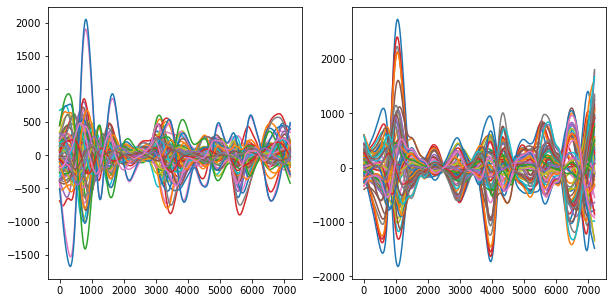

In [20]:
time_span = np.linspace(0, paras.T, Ymat_AD.shape[-1])

if not ("dXXmats_AD" in cur_res.keys()):
    dXmats_AD, Xmats_AD = get_bspline_est(Ymat_AD, time_span, paras.lamb)
    dXmats_ctrl, Xmats_ctrl = get_bspline_est(Ymat_ctrl, time_span, paras.lamb)
    cur_res.dXXmats_AD = [dXmats_AD, Xmats_AD]
    cur_res.dXXmats_ctrl = [dXmats_ctrl, Xmats_ctrl]
    save_pkl_dict2folder(_paras.save_dir, cur_res)

dXmats_AD, Xmats_AD = cur_res.dXXmats_AD
dXmats_ctrl, Xmats_ctrl = cur_res.dXXmats_ctrl

plt.figure(figsize=[10, 5])
plt.subplot(121)
for ix in range(68):
    plt.plot(Xmats_AD[0, ix, :])
plt.subplot(122)
for ix in range(68):
    plt.plot(Xmats_ctrl[0, ix, :])

In [21]:
if not ("Amat_AD" in cur_res.keys()):
    Amats_ADs_lowrank = get_Amats(dXmats_AD[:], Xmats_AD[:], time_span, downrate=paras.downsample_rate, 
                              fct=paras.fct, nRks=paras.num_ranks, is_stack=False)
    Amat_AD = np.sum(Amats_ADs_lowrank, axis=0)
    cur_res.Amat_AD = Amat_AD
    save_pkl_dict2folder(_paras.save_dir, cur_res)
Amat_AD = cur_res.Amat_AD

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [01:31<00:00,  1.04s/it]

/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dXXmats_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dXXmats_ctrl.pkl exists! Use is_force=True to save it anyway
Save to /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/Amat_AD.pkl


In [22]:
if not ("Amat_ctrl" in cur_res.keys()):
    Amats_ctrls_lowrank = get_Amats(dXmats_ctrl[:], Xmats_ctrl[:], time_span, downrate=paras.downsample_rate, 
                              fct=paras.fct, nRks=paras.num_ranks, is_stack=False)
    Amat_ctrl = np.sum(Amats_ctrls_lowrank, axis=0)
    cur_res.Amat_ctrl = Amat_ctrl
    save_pkl_dict2folder(_paras.save_dir, cur_res)
Amat_ctrl = cur_res.Amat_ctrl

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [01:24<00:00,  1.04it/s]

/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dXXmats_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dXXmats_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/Amat_AD.pkl exists! Use is_force=True to save it anyway
Save to /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/Amat_ctrl.pkl


### Dim reduction

In [24]:
if not ("dim_redu_ctrl" in cur_res.keys()):
    cur_res.dim_redu_ctrl = get_newdata(dXmats_ctrl, Xmats_ctrl, Amat_ctrl, paras.r, True)
    save_pkl_dict2folder(_paras.save_dir, cur_res)
    
if not ("dim_redu_AD" in cur_res.keys()):
    # note that I use Amat from ctrl group to reduce the dim for AD data
    cur_res.dim_redu_AD = get_newdata(dXmats_AD, Xmats_AD, Amat_ctrl, paras.r, True)
    save_pkl_dict2folder(_paras.save_dir, cur_res)

/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dXXmats_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dXXmats_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/Amat_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/Amat_ctrl.pkl exists! Use is_force=True to save it anyway
Save to /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dim_redu_ctrl.pkl
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dXXmats_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../

### Candidate detection

In [25]:
if not ("can_pts_ctrls" in cur_res.keys()):
    can_pts_ctrls = screening(cur_res.dim_redu_ctrl.ndXmats, 
                              cur_res.dim_redu_ctrl.nXmats,
                              cur_res.dim_redu_ctrl.kpidxs,
                              wh=paras.wh, 
                              showProgress=True)
    cur_res.can_pts_ctrls = can_pts_ctrls
    save_pkl_dict2folder(_paras.save_dir, cur_res)

Screening: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [11:20<00:00,  7.73s/it]

/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dXXmats_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dXXmats_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/Amat_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/Amat_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dim_redu_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dim_redu_AD.pkl exists! Use is_force=True to save it anyway
Save to /data/rajlab1/user_data/jin/MyResear

In [26]:
if not ("can_pts_ADs" in cur_res.keys()):
    can_pts_ADs = screening(cur_res.dim_redu_AD.ndXmats, 
                            cur_res.dim_redu_AD.nXmats,
                            cur_res.dim_redu_AD.kpidxs,
                            wh=paras.wh, 
                            showProgress=True)
    cur_res.can_pts_ADs = can_pts_ADs
    save_pkl_dict2folder(_paras.save_dir, cur_res)

Screening: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [11:18<00:00,  7.71s/it]

/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dXXmats_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dXXmats_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/Amat_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/Amat_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dim_redu_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dim_redu_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN

### CPT detection

In [17]:
if not ("cpts_ctrls" in cur_res.keys()):
    cpts_ctrls = []
    for ix in trange(len(cur_res.can_pts_ctrls)):
        res = dyna_prog(cur_res.dim_redu_ctrl.ndXmats[ix], 
                        cur_res.dim_redu_ctrl.nXmats[ix],
                        paras.kappa, 
                        cur_res.dim_redu_ctrl.kpidxs,
                        Lmin=paras.Lmin,  
                        canpts=cur_res.can_pts_ctrls[ix], 
                        MaxM=paras.maxM,  
                        is_full=True,  
                        showProgress=False)
        cpts_ctrls.append(res)
    
    cur_res.cpts_ctrls = cpts_ctrls
    save_pkl_dict2folder(_paras.save_dir, cur_res)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [24:11<00:00, 16.50s/it]

/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dXXmats_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dXXmats_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/Amat_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/Amat_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dim_redu_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dim_redu_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN

In [18]:
if not ("cpts_ADs" in cur_res.keys()):
    cpts_ADs = []
    for ix in trange(len(cur_res.can_pts_ADs)):
        res = dyna_prog(cur_res.dim_redu_AD.ndXmats[ix], 
                        cur_res.dim_redu_AD.nXmats[ix],
                        paras.kappa, 
                        cur_res.dim_redu_AD.kpidxs,
                        Lmin=paras.Lmin,  
                        canpts=cur_res.can_pts_ADs[ix], 
                        MaxM=paras.maxM,  
                        is_full=True,  
                        showProgress=False)
        cpts_ADs.append(res)
    
    cur_res.cpts_ADs = cpts_ADs
    save_pkl_dict2folder(RES_ROOT/_paras.folder_name, cur_res)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [24:27<00:00, 16.68s/it]

/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dXXmats_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dXXmats_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/Amat_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/Amat_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dim_redu_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dim_redu_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN

#### Results of switching pts

3.2612612612612613

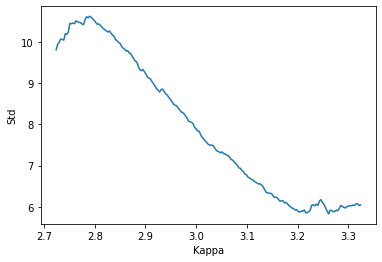

In [407]:
# sel kappa
ecptssCtrls = []
_, curR, n = ResCtrl.ndXmats.shape
for kp in paras.kps:
    ecptssCtrl = np.array([UpdateKp(kp, ix.U0, n, curR, paras) for ix in detRessCtrl])
    ecptssCtrls.append(ecptssCtrl)
    
ecptssAD_CtrlUs = []
_, curR, n = ResAD_CtrlU.ndXmats.shape
for kp in paras.kps:
    ecptssAD_CtrlU = np.array([UpdateKp(kp, ix.U0, n, curR, paras) for ix in detRessAD_CtrlU])
    ecptssAD_CtrlUs.append(ecptssAD_CtrlU)

ecptssCtrls = np.array(ecptssCtrls)
ecptssAD_CtrlUs = np.array(ecptssAD_CtrlUs)
stdRes = ecptssAD_CtrlUs.std(axis=1) + ecptssCtrls.std(axis=1)
meanRes = ecptssAD_CtrlUs.mean(axis=1) + ecptssCtrls.mean(axis=1)

kpsKpidxs1 = np.bitwise_and(ecptssCtrls.mean(axis=1)>=2, ecptssCtrls.mean(axis=1)<=18)
kpsKpidxs2 = np.bitwise_and(ecptssAD_CtrlUs.mean(axis=1)>=2, ecptssAD_CtrlUs.mean(axis=1)<=18)
kpsKpidxs = np.bitwise_and(kpsKpidxs1, kpsKpidxs2)


plt.plot(paras.kps[kpsKpidxs], stdRes[kpsKpidxs])
plt.xlabel("Kappa")
plt.ylabel("Std")


selKp = paras.kps[kpsKpidxs][np.argmin(stdRes[kpsKpidxs])]
selKp

In [379]:
curKp = selKp
_, curR, n = ResCtrl.ndXmats.shape
ecptssCtrl = np.array([UpdateKp(curKp, ix.U0, n, curR, paras) for ix in detRessCtrl])
_, curR, n = ResAD_CtrlU.ndXmats.shape
ecptssAD_CtrlU = np.array([UpdateKp(curKp, ix.U0, n, curR, paras) for ix in detRessAD_CtrlU])

3.4886363636363638 6.806818181818182


Ttest_indResult(statistic=-7.497186039159376, pvalue=3.1857560708074315e-12)

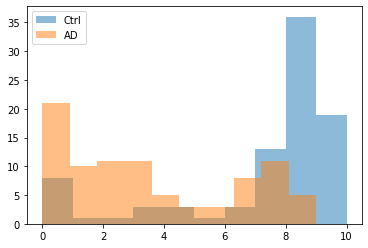

In [381]:
print(np.mean(ecptssAD_CtrlU), np.mean(ecptssCtrl))
ttest_ind(ecptssAD_CtrlU, ecptssCtrl)
plt.hist(ecptssCtrl, alpha=0.5, label="Ctrl")
plt.hist(ecptssAD_CtrlU, alpha=0.5, label="AD")
plt.legend()

Text(0.5, 1.0, 'Num of switching points (T-test:0.000)')

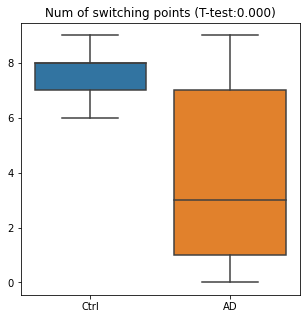

In [382]:
res = ttest_ind(ecptssCtrl, ecptssAD_CtrlU, equal_var=False)
plt.figure(figsize=[5, 5])
sns.boxplot(data=[ecptssCtrl, ecptssAD_CtrlU], showfliers=0)
plt.xticks([0, 1], ["Ctrl", "AD"])
plt.title(f"Num of switching points (T-test:{res.pvalue:.3f})")

#### Results of rks

In [401]:
paras.L1 = 25000
paras.L = 200

rksCtrl = []
kpidxs = ResCtrl.kpidxs
for ix in range(len(detRessCtrl)):
    ndXmat = ResCtrl.ndXmats[ix]
    nXmat = ResCtrl.nXmats[ix]
    necpts = ecptssCtrl[ix]
    ecpts = detRessCtrl[ix].chgMat[necpts-1, :necpts]
    eigValsMat = estEigVals(ecpts, ndXmat, nXmat, kpidxs)
    #eigValsMat = euclidean_proj_l1ball_CplxMul(eigValsMat, paras.L1)
    _, redRowNorms = euclidean_proj_l1ball_CplxMat(eigValsMat, paras.L)
    curKpidxs = np.intersect1d(np.where(redRowNorms!=0)[0], kpidxs)
    
    curRk = np.sum(redRowNorms != 0)
    rksCtrl.append(curRk)

In [402]:
rksAD_CtrlU= []
kpidxs = ResAD_CtrlU.kpidxs
for ix in range(len(detRessAD_CtrlU)):
    ndXmat = ResAD_CtrlU.ndXmats[ix]
    nXmat = ResAD_CtrlU.nXmats[ix]
    necpts = ecptssAD_CtrlU[ix]
    ecpts = detRessAD_CtrlU[ix].chgMat[necpts-1, :necpts]
    eigValsMat = estEigVals(ecpts, ndXmat, nXmat, kpidxs)
    #eigValsMat = euclidean_proj_l1ball_CplxMul(eigValsMat, paras.L1)
    _, redRowNorms = euclidean_proj_l1ball_CplxMat(eigValsMat, paras.L)
    curKpidxs = np.intersect1d(np.where(redRowNorms!=0)[0], kpidxs)
    
    curRk = np.sum(redRowNorms != 0)
    rksAD_CtrlU.append(curRk)
    #print(np.std(redRowNorms))

18.03409090909091 17.420454545454547
Ttest_indResult(statistic=1.5575483102519536, pvalue=0.12115734336100596)


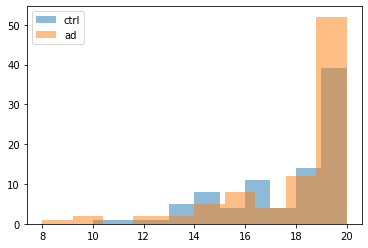

In [403]:
print(np.mean(rksAD_CtrlU), np.mean(rksCtrl))
print(ttest_ind(rksAD_CtrlU, rksCtrl))
plt.hist(rksCtrl, alpha=0.5, label="ctrl")
plt.hist(rksAD_CtrlU, alpha=0.5, label="ad")
plt.legend()

Text(159.0, 0.5, 'Rank')

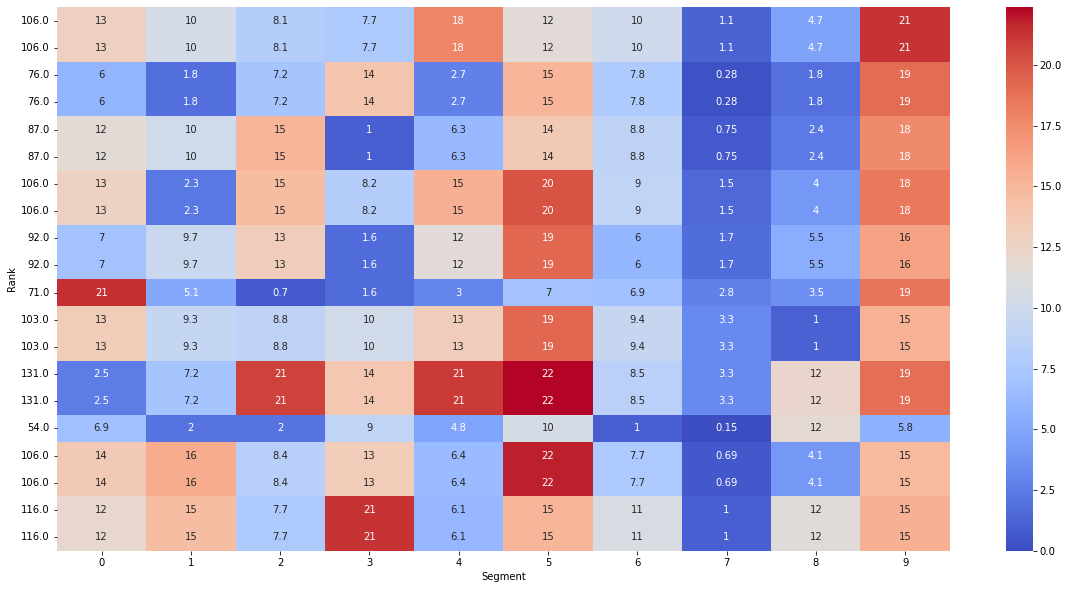

In [405]:
ix = 2
kpidxs = ResAD_CtrlU.kpidxs
ndXmat = ResAD_CtrlU.ndXmats[ix]
nXmat = ResAD_CtrlU.nXmats[ix]
ecpts = detRessAD_CtrlU[ix].mbic_ecpts

plt.figure(figsize=[20, 10])

plt.subplot(111)
eigValsMat = estEigVals(ecpts, ndXmat, nXmat, kpidxs)
rowNorms = (np.sum(np.abs(eigValsMat), axis=1))
sns.heatmap(np.abs(eigValsMat), yticklabels=np.round(rowNorms, 0), cmap="coolwarm", annot=np.abs(eigValsMat), vmin=0)
plt.xlabel("Segment")
plt.ylabel("Rank")

# plt.subplot(132)
# redEigValsMat, redRowNorms = euclidean_proj_l1ball_CplxMat(eigValsMat, paras.L)
# sns.heatmap(np.abs(redEigValsMat), yticklabels=np.round(redRowNorms, 0), cmap="coolwarm", annot=np.abs(redEigValsMat), vmin=0)
# plt.xlabel("Segment")
# plt.ylabel("Rank")
# 
# plt.subplot(133)
# eigValsMat1 = euclidean_proj_l1ball_CplxMul(eigValsMat, paras.L1)
# redEigValsMat1, redRowNorms1 = euclidean_proj_l1ball_CplxMat(eigValsMat1, paras.L)
# sns.heatmap(np.abs(redEigValsMat1), yticklabels=np.round(redRowNorms1, 0), cmap="coolwarm", annot=np.abs(redEigValsMat1), vmin=0)
# plt.xlabel("Segment")
# plt.ylabel("Rank")